<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/01_pytorch_workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow

Resources :
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of the notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
what_are_we_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting or model to the data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "save an load a model",
    6 : "putting it all together",
}

what_are_we_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting or model to the data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'save an load a model',
 6: 'putting it all together'}

In [2]:
import torch
from tqdm import tqdm
import numpy as np
from torch import nn #nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## 1.Data (preparing and loading)

Data can be almost anything ... in machine learning

* Excel spreadsheet
* Image of any type
* Video
* Audio
* DNA
* Text

Machine Learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this let's create some *known* data using linear regression formula (y=mx+b)

Well use a linear regression formula to make a straight line with known **parameters**


In [3]:
# Create *known* parameteres y = mx + b

weight = 0.7 #  weight => m
bias = 0.3   #  bias => b

# Create
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # X is capital => a tensor
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

# Splinting data into training and tests sets (One of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [5]:
# Create train/test split

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data ?

This is where the data explorer's motto comes in !

"Visualize, Visualize, Visualize !"

In [6]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  Plots training data, test data and compare predicitions.
  """

  plt.figure(figsize=(10,7))

  # Plot training data in blue

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in gree
  plt.scatter(test_data, test_labels, c="g", s=4, label= "Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")


  # Show the legends

  plt.legend(prop={"size": 14})

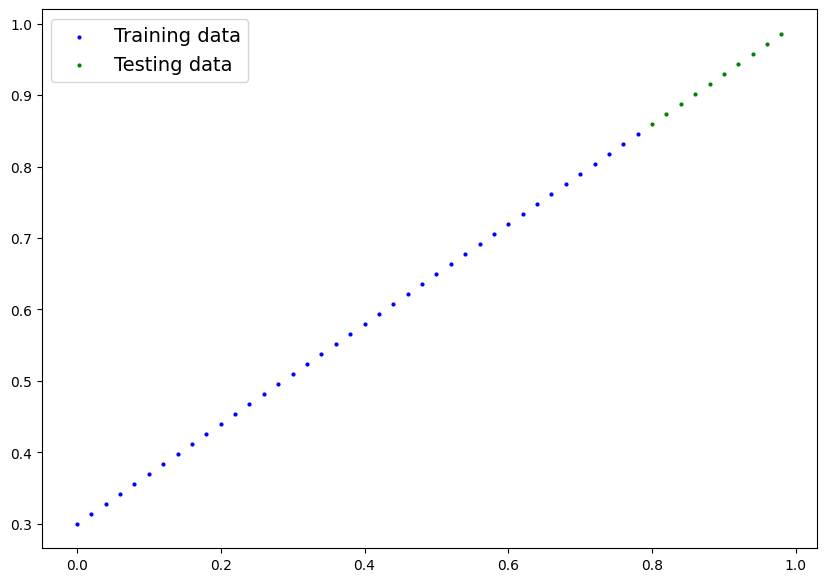

In [7]:
plot_prediction()

## 2. Build model

Our first PyTorch model !


What our model does:
* Start with random values (weight, bias)
* Look at training data and adjust the random values to better
  represent (or get closer) to ideal values (the weight and bias values we used to create the data)

How does it do so ?

Through two main algorithms:

1. Gradiant Descent - https://www.youtube.com/watch?v=IHZwWFHWa-w&ab_channel=3Blue1Brown
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U&ab_channel=3Blue1Brown



In [8]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # <= lego building bricks of Neural Network in PyTorch
    def __init__(self):
      super().__init__()
      self.weights = nn.Parameter(
        torch.randn(
          1,
          requires_grad=True,
          dtype=torch.float
      ))
      self.bias = nn.Parameter(
          torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
      ))
    # `forward()` method to define the computation in the model (you must overide it)
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <= "x" is the input data
        return self.weights * x + self.bias # This is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the building blocks for computational graph(another word for neural network which can be considered a computation graph)
* torch.nn.Paramater -  What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - Base class for all NN module, if you subclass it you should overide foward
* torch.optim - This is where the optimizers in PyTorch live, they will help with gradiant descent
* def foward() - All nn.Module subclasses require you to overwrite foward(), this method define what occur in the foward computation

Resource:
* PyTorch CheatSheet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the content of our PyTorch model

Now we have created a model let's see what is inside...

We can check out our model parameters using `.parameters()`

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
weight, bias

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check out model predicting power let's see how well it predicts `y_test` based on `X_test`

When we pass data to our model it it's going to run it through the `foward()` method

In [12]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [13]:
# Make predictions with model
with torch.inference_mode(): #Context manager for making inference mode
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference here - https://twitter.com/PyTorch/status/1437838231505096708?s=20

In [14]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

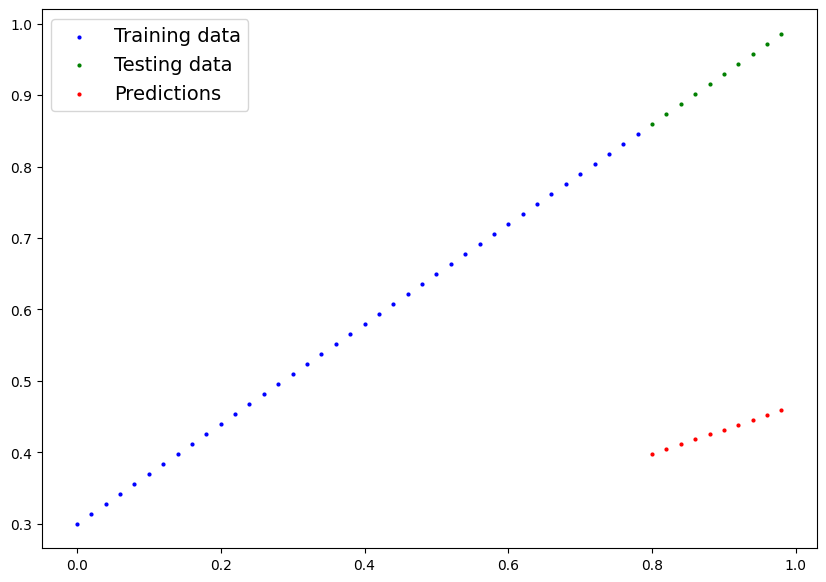

In [15]:
plot_prediction(predictions=y_preds)

## 3. Train model

The whole idea of training is to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to mesure how poor or how wrong our model prediction are is to use a loss function.

**Note** : *Loss function* may be called *cost function* or *criterion* in different areas. For our case we are going to refer to it as a loss function.

Things we need to train:


**Loss function:** A function to mesure how wrong our model predicition are to ideal output, lower is better.


**Optimizer:** Take into account the loss and adjusts the model's parameters (e.g. weights and bias) in our case to improve the loss function.
  * Inside the optimizer you'll often have to set to parameters:
      * `params` - the model parameters you'd like to optimize for example `params=model_0.parameters()
      * `lr`(learning rate) - the learning rate is an hyperparameter that define how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)


And specificaly for PyTorch we need :
* A training loop
* A testing loop

Resources :
* Loss functions - https://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers - https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer

In [16]:
# Check out our model's parameters(a parameter is a value that the model set itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Setup a loss function => How wrong our model his
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradiant descent) => Adjust paramaters to reduce loss
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # lr = learning rate the most important hyperparameters in ML

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop

0. Loop through the data
1. Foward pass (this involves data moving through our model `forward()` functions to make prediction on data - also called forward propagation
2. Calculate the loss (compare foward pass predicitons to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters with respect to the loss (**backpropagation** - https://www.youtube.com/watch?v=tIeHLnjs5U8)
5. Optimizer step - use the optimizer to adjust our model parameters to adjust our model parameters to try and improve the loss(**gradiant descent** - https://youtu.be/IHZwWFHWa-w)

In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
# An epochs is one loop through the data (this is a hyperparameter) because we set them ourselfs
epochs = 200

#Tracking experiment
epoch_count = []
loss_values = []
test_loss_values = []


### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set model in training mode
  model_0.train() # train. mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Foward pass(Foward propagation)
  y_pred = model_0.forward(X_train)

  #2. Calculate the loss (how different are the model's predictions to the true values)
  loss = loss_fn(y_pred, y_train)

  #3. Optimizer zero grad (Zero the gradiants since they accumulate by default)
  optimizer.zero_grad()

  #4. Perform Backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so ... we have to zero them above in step 3

  ## Testing
  model_0.eval() #turns off different settings in the model not needed for evaluation (dropout/batch norm layers)

  with torch.inference_mode(): # This turns of gradiant tracking & couple of thing behind the scene (you might also see torch.no_grad() in older PyTorch Code)
    # 1. Do the foward pass
    test_pred = model_0.forward(X_test)

    # 2. Calculate test lost
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    # Print out what's happenin.....
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test loss:{test_loss} |||| weight:{model_0.state_dict()['weights']} | bias: {model_0.state_dict()['bias']} ")

Epoch: 0 | Train Loss: 0.31288138031959534 | Test loss:0.48106518387794495 |||| weight:tensor([0.3406]) | bias: tensor([0.1388]) 
Epoch: 10 | Train Loss: 0.1976713240146637 | Test loss:0.3463551998138428 |||| weight:tensor([0.3796]) | bias: tensor([0.2388]) 
Epoch: 20 | Train Loss: 0.08908725529909134 | Test loss:0.21729660034179688 |||| weight:tensor([0.4184]) | bias: tensor([0.3333]) 
Epoch: 30 | Train Loss: 0.053148526698350906 | Test loss:0.14464017748832703 |||| weight:tensor([0.4512]) | bias: tensor([0.3768]) 
Epoch: 40 | Train Loss: 0.04543796554207802 | Test loss:0.11360953003168106 |||| weight:tensor([0.4748]) | bias: tensor([0.3868]) 
Epoch: 50 | Train Loss: 0.04167863354086876 | Test loss:0.09919948130846024 |||| weight:tensor([0.4938]) | bias: tensor([0.3843]) 
Epoch: 60 | Train Loss: 0.03818932920694351 | Test loss:0.08886633068323135 |||| weight:tensor([0.5116]) | bias: tensor([0.3788]) 
Epoch: 70 | Train Loss: 0.03476089984178543 | Test loss:0.0805937647819519 |||| weigh

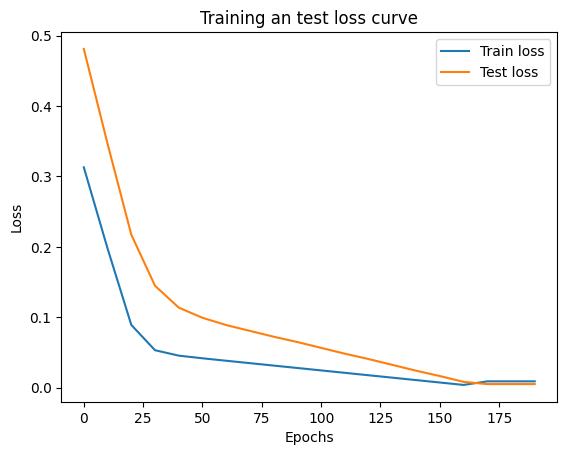

In [20]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training an test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [21]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

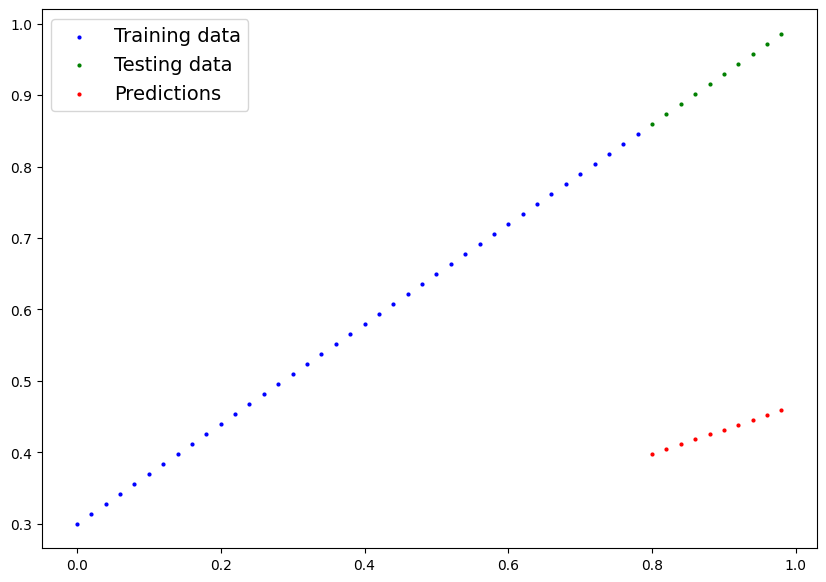

In [22]:
# Previous prediction (at the beginning)
plot_prediction(predictions=y_preds)

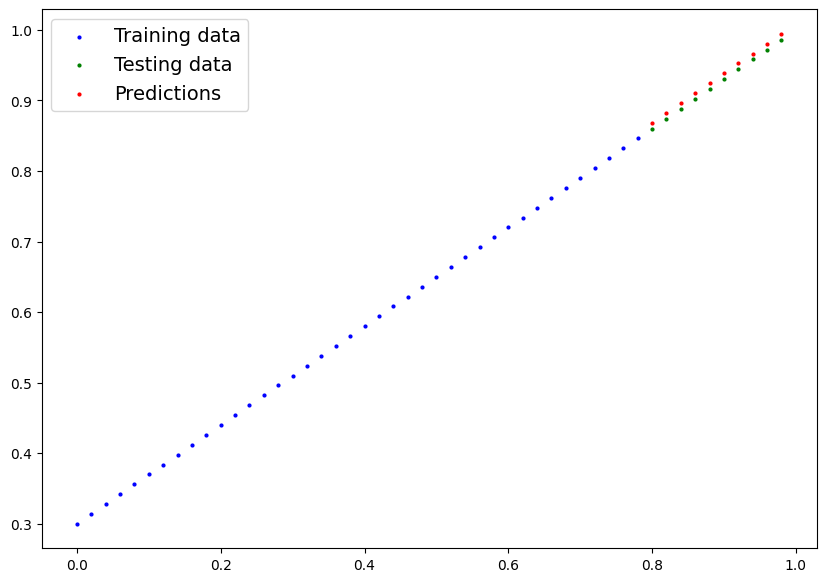

In [23]:
# Result after training for about 200 epochs
plot_prediction(predictions=y_preds_new)

## Saving PyTorch Model

There are three main methods you should know about saving and loading models in PyTorch.

1. `torch.save()` - allows to save a PyTorch object into Python Pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.load_state_dict()`- this allows to load a model's saved state dictionary

PyTorch save and load code tutorial - https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
## Saving out our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [26]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Jul 14 19:28 01_pytorch_workflow_model_0.pth


In [27]:
## Loading a PyTorch Model
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [28]:
# Since we saved only the state dict we will create a new model an load the state dict into it
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
# Make some predicitons with our loaded model
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [31]:
# Make some predicitons with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [32]:
y_preds == loaded_model_preds # Both preds match so model is the same !

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [33]:
# Import PyTorch and matplotlit
import torch
from torch import nn
import matplotlib.pyplot as plt


# Checkout PyTorch version
torch.__version__

'2.0.1+cu118'

Create device agnostic code

This means if we've got acess to a GPU our code will user it (Faster Compution)

If no GPU is avaialbe the code will default to CPU

In [35]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device:cuda


### 6.1 Data

In [37]:
# Create some data using the linear regression formula y = weight*X + bias
weight = 0.7
bias = 0.3

# Create range value
start = 0
end = 1
step = 0.02

# Create X and y (features and lablels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [38]:
# Split data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

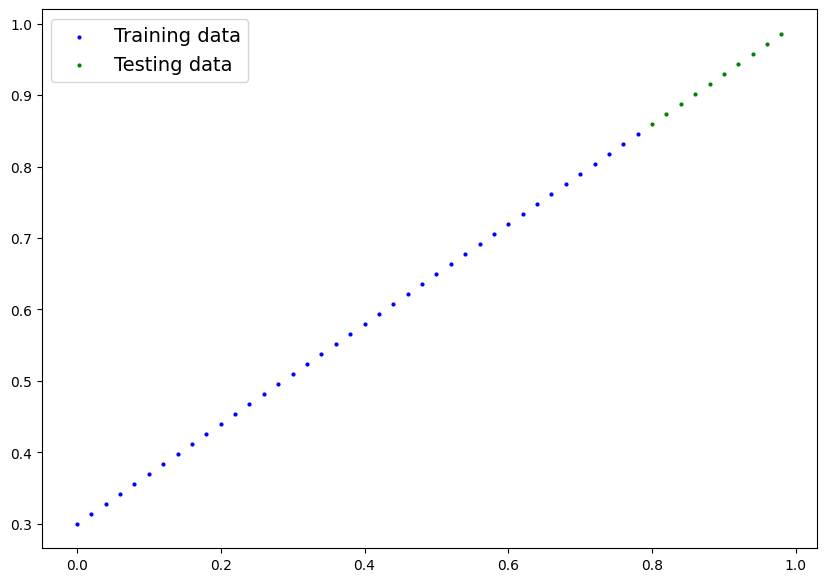

In [39]:
# Plot the data
plot_prediction(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [43]:
# Create a linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Let's use torch linear layer using nn.Linear() / also called linear transform, fully connected layer, probing layer, dense layer
    self.linear_layer = nn.Linear(
        in_features=1, # In our data we have 1 feature or X
        out_features=1 # In our data we have 1 feature of y
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor :
      return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)

# Create an instance of our model
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [46]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [47]:
# Set the model to use the target device
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [48]:
# Check the model current device again
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need :
* Loss function : Mesure how wrong our model is.
* Optimizer : Optimize params of our model.
* Training loop
* Testing loop

In [49]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [50]:
# Let's setup our loss function
loss_fn = nn.L1Loss() #Same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [56]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200


# Put data on the target device (device agnostic code for data)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  #1. Forward pass
  y_pred = model_1(X_train)

  #2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  #3. Reset Gradients
  optimizer.zero_grad()

  #4. Perform backpropagation
  loss.backward()

  #5. Optimizer step
  optimizer.step()


  ## Testing
  model_1.eval()
  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what is happening
  if epoch % 10 == 0:
    print(f"Epoch:  {epoch} | Loss: {loss} | Test loss :{test_loss}")


Epoch:  0 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  10 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  20 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  30 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  40 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  50 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  60 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  70 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  80 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  90 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  100 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  110 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  120 | Loss: 0.0012645035749301314 | Test loss :0.013801801018416882
Epoch:  130 | Loss: 0.0

In [57]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [55]:
weight, bias

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [60]:
# Turn model into evaluation mode
model_1.eval()

# Make predicitons on the test data

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

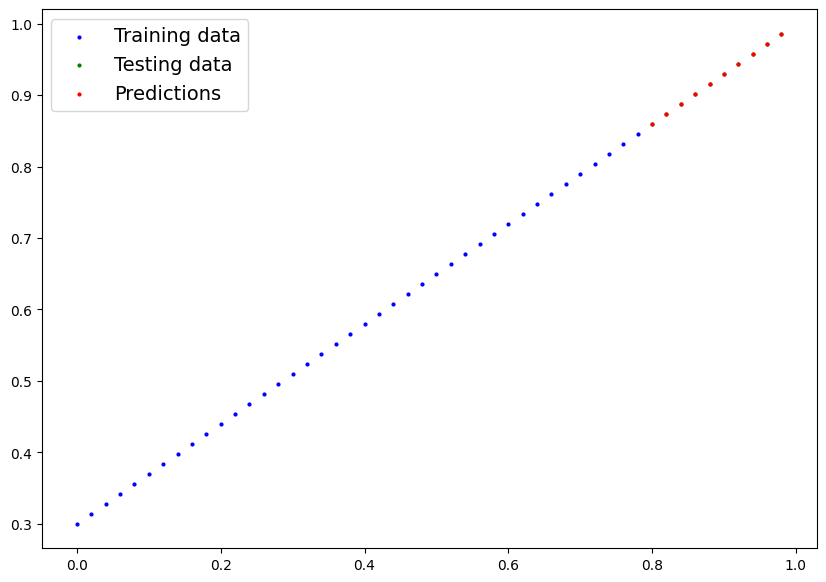

In [61]:
# Check out our model predicitions visually

plot_prediction(predictions=y_preds.cpu())

### 6.5 Saving an loading a train model

In [65]:
## Saving model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

In [69]:
# Loading a PyTorch model from file
loaded_model_1 = LinearRegressionModelV2()

# Load the save model state dict to model
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

#Put the loaded model to the device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [70]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [71]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [72]:
# Evaluate loaded model
loaded_model_1.eval()\

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')